<a href="https://colab.research.google.com/github/g23polar/ml/blob/main/KNN_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming assignment 1: KNN classifier

In this programming exercise, we will build a KNN classifier and apply it to a handwritten digit dataset (MNIST). Please download the datasets from Canvas and put them in the same folder of this iPython notebook.

Instructions for submission: please submit the following:
* Completed iPython notebook. We will inspect the code and run your notebook.
* Solutions to the corresponding problems




## 1. The MNIST dataset

`MNIST` is a classic database of handwritten digits that is commonly used for training various image processing systems. The MNIST database contains 60,000 training images and 10,000 testing images. In this notebook we will work with a subset of this data: a training set of 2,000 images and a test set of 500 images. Each image is given by 28 X 28 grayscale pixels.

First, let's first load the dataset check the basic statistics.


In [266]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt 
import time
import random
from progressbar import ProgressBar

In [267]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [268]:
#Append the directory to your python path using sys

import sys
prefix = '/content/gdrive/My Drive/hw_ml/'

# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_your_homework = 'hw1/ProgAs1/ProgAs1_notebook_data'
sys_path = prefix + customized_path_to_your_homework
sys.path.append(sys_path)
print(sys_path)

/content/gdrive/My Drive/hw_ml/hw1/ProgAs1/ProgAs1_notebook_data


In [269]:
## Load the training set
# To speed up computation, we will just consider 7000 images for training and 100 images for testing
num_trn, num_tst = 2000,500
train_data = np.load(sys_path+'/mnist_train_data.npy')[:num_trn,]
train_labels = np.load(sys_path+'/mnist_train_labels.npy')[:num_trn]

## Load the testing set
test_data = np.load(sys_path+'/mnist_test_data.npy')[:num_tst,]
test_labels = np.load(sys_path+'/mnist_test_labels.npy')[:num_tst]


## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))



('Training dataset dimensions: ', (2000, 784))
('Number of training labels: ', 2000)
('Testing dataset dimensions: ', (500, 784))
('Number of testing labels: ', 500)
Training set distribution:
{0: 204, 1: 219, 2: 200, 3: 209, 4: 186, 5: 194, 6: 189, 7: 200, 8: 214, 9: 185}
Test set distribution:
{0: 49, 1: 53, 2: 63, 3: 42, 4: 49, 5: 43, 6: 42, 7: 56, 8: 48, 9: 55}


Now, let's randomly choose 10 images from the training dataset and visualize them.

[310, 20, 704, 156, 688, 1847, 1294, 45, 402, 105]


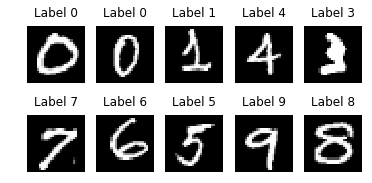

In [270]:
nrows, ncols = 2, 5
index = random.sample(range(len(train_labels)), 10)
print index
fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3))
for i in range(nrows):
    for j in range(ncols):
        # Image index
        k = j + i * ncols
        ax = axes[i, j]
        ax.matshow((train_data[index[k],]).reshape((28,28)),cmap=plt.cm.gray)
        ax.set_axis_off()
        ax.set_title("Label " + str(train_labels[index[k]]))

## 2. KNN based on Euclidean distance

Let's first experiment with _Euclidean distance_: for two vectors $x, y \in \mathbb{R}^d$, their Euclidean distance is defined as 
$$\|x - y\| = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}.$$
**Task P2.1:** Complete the following code section to calculate this distance. Copy the corresponding code to the problem set 1 solution pdf file.

In [271]:
## Computes squared Euclidean distance between two vectors.
import math
def eucl_dist(x,y):
    # input:
    # x, y: vectorization of an image
    # output:
    # the distance between the two vectors
    
    ### STUDENT: YOUR CODE HERE

    return np.sqrt(np.sum(np.square(x-y)))
    ### CODE ENDS

# a = np.array([0, 0, 0])
# b = np.array([1, 1, 1])
# print(eucl_dist(a, b))

Now, let's try to compute the distance between some randomly chosen images.

In [272]:
index = random.sample(range(len(train_labels)), 10)
for i in range(5):
    # Image index
    k = i * 2
    print("Distance from "+str(train_labels[index[k]])+" to "+str(train_labels[index[k+1]])+": "+
          str(eucl_dist(train_data[index[k],],train_data[index[k+1],])))
    


Distance from 9 to 7: 2887.0593
Distance from 0 to 8: 2687.9785
Distance from 2 to 9: 2945.9026
Distance from 5 to 3: 2436.297
Distance from 1 to 8: 2060.0256


Now, let's implement the K-nearest neighbor classification. 

**Task P2.2:** Complete the following code sections for `find_KNN` and `KNN_classifier`. Copy the corresponding code to the problem set 1 solution pdf file.

In [273]:
# Take a vector x and returns the indices of its K nearest neighbors in the training set: train_data
def find_KNN(x, train_data, train_labels, K, dist=eucl_dist):
    # Input: 
    # x: test point
    # train_data: training data X
    # train_labels: training data labels y
    # K: number of nearest neighbors considered
    # dist: default to be the eucl_dist that you have defined above
    # Output:
    # The indices of the K nearest neighbors to test point x in the training set
    
    ##### STUDENT: Your code here #####
    temps = []
    indices = []
    for index in range(len(train_data)):

        d = dist(x, train_data[index])

        temps.append((train_data[index], d, train_labels[index] , index))
    
    temps.sort(key=lambda x: x[1])
    neighbors = temps[:K]   
    
    for n in neighbors:
      indices.append(n[3])
    # print(indices)
    return indices

  
    ##### END OF CODE #####



Now, you should make use of the `find_KKN` function to define the KNN classifier.

In [274]:
# KNN classification
def KNN_classifier(x, train_data, train_labels,K,dist=eucl_dist):
    # Input:
    # x: test point
    # train_data: training data X
    # train_labels: training data labels y
    # K: number of nearest neighbors considered
    # dist: default to be the eucl_dist that you have defined above
    
    ##### STUDENT: Your code here #####
    idxs = find_KNN(x, train_data, train_labels, K, dist)
    print(idxs)
    s = 0
    for idx in idxs:
      s = s + train_labels[idx]
    b = float(s)/K 
    if (b<0.5):
       return (0)
    return (1)

      

    ##### END OF CODE #####
# x1 = np.array([10, 10])
# trdata = [np.array([1, 1]), np.array([0, 0]), np.array([9, 9]), np.array([432, 281]), np.array([101, 100]), np.array([100, 100])]
# trlabs = [0, 0, 1, 1, 1, 1]
# print("here on")
# # find_KNN(x1, trdata, trlabs, 2, eucl_dist)
# KNN_classifier(x1, trdata, trlabs, 3, eucl_dist)

Now, let's examine how the code works for 1-NN (i.e., with K=1).

In [275]:
## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    plt.axis('off')
    if(dataset=="train"): 
        plt.imshow((train_data[index,]).reshape((28,28)), cmap=plt.cm.gray)
        label = train_labels[index]
    else:
        plt.imshow((test_data[index,]).reshape((28,28)), cmap=plt.cm.gray)
        label = test_labels[index]
    plt.show()
    print("Label " + str(label))
    return

**Task P2.3: Find one example of success case and one example of failed case for 1-NN. Print the outputs and copy them to the problem set solution file.**

A success case:
[1922]
('1-NN classification: ', 0)
('True label: ', 0)
The test image:


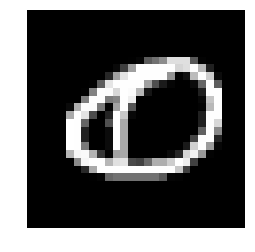

Label 0
The corresponding nearest neighbor image:


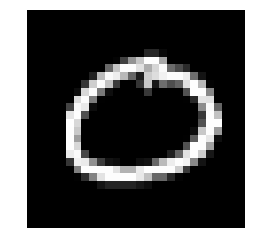

Label 0
Index = 24
A failure case:
[1451]
('NN classification: ', 1)
('True label: ', 3)
The test image:


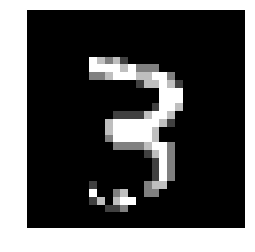

Label 3
The corresponding nearest neighbor image:


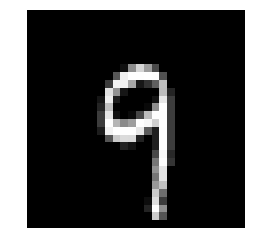

Label 9


In [276]:
## A success case:
ind_success = 0

print("A success case:")
print("1-NN classification: ", KNN_classifier(test_data[ind_success,],train_data,train_labels,1,eucl_dist))
print("True label: ", test_labels[ind_success])
print("The test image:")
vis_image(ind_success, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_KNN(test_data[ind_success,],train_data,train_labels,1,eucl_dist)[0], "train")

## A failure case:
ind_fail = 24
print("Index = " + str(ind_fail))
print("A failure case:")
print("NN classification: ", KNN_classifier(test_data[ind_fail,],train_data,train_labels,1,eucl_dist))
print("True label: ", test_labels[ind_fail])
print("The test image:")
vis_image(ind_fail, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_KNN(test_data[ind_fail,],train_data,train_labels,1,eucl_dist)[0], "train")
  

Now let's apply our K-nearest neighbor classifier over the full data set with `K=3`. 

Note that to classify each test point, our code takes a full pass over each of the 2000 training examples. The following code takes about 8 seconds on 3.3 GHz Intel Core i. 

**Task P2.4: Report the outputs of the following code and copy them to the problem set solution file.**

In [277]:
## Predict on each test data point (and time it!)
pbar = ProgressBar() # to show progress
t_before = time.time()
test_predictions = np.zeros(len(test_labels))
for i in pbar(range(len(test_labels))):   
    test_predictions[i] = KNN_classifier(test_data[i,],train_data,train_labels,3,eucl_dist)
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier with Euclidean distance: ", error)
print("Classification time (seconds) with Euclidean distance: ", t_after - t_before)

  0% (4 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13

[1922, 1421, 1593]
[1363, 515, 1888]
[1144, 56, 749]
[1307, 1142, 1793]
[794, 218, 1881]
[749, 213, 1875]


  1% (7 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13

[802, 1432, 1630]
[761, 783, 1476]
[1081, 556, 891]
[496, 1060, 1157]
[563, 417, 83]


  2% (13 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:10

[1538, 1972, 16]
[323, 1654, 564]
[1218, 1430, 539]
[1003, 1431, 691]
[242, 1255, 790]
[1542, 92, 564]


  3% (18 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:10

[348, 659, 1632]
[1719, 82, 188]
[1811, 604, 1302]
[697, 287, 234]


  4% (24 of 500) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:10

[720, 971, 710]
[1076, 310, 1908]
[894, 1162, 1008]
[1451, 789, 840]
[1405, 1538, 1216]
[762, 899, 490]
[1300, 1598, 1178]


  6% (30 of 500) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:09

[45, 1236, 119]
[394, 1413, 183]
[829, 936, 1476]
[357, 384, 931]


  7% (36 of 500) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:09

[1872, 528, 50]
[1783, 1982, 1246]
[1148, 1671, 954]
[1930, 119, 1918]
[807, 470, 92]
[1468, 1285, 1668]
[461, 1849, 516]


  8% (41 of 500) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:09

[211, 1587, 133]
[1054, 1041, 819]
[192, 1519, 702]


  9% (45 of 500) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:09

[1777, 594, 864]
[757, 1335, 326]
[338, 1893, 1495]
[1904, 1843, 1869]
[944, 610, 1591]
[54, 238, 1370]
[716, 768, 1100]


 10% (50 of 500) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:09

[1862, 144, 1192]
[1778, 1434, 894]
[1929, 497, 666]


 11% (55 of 500) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:09

[1996, 669, 1980]
[1603, 1154, 1462]
[851, 1584, 1375]
[1307, 1114, 1324]
[1024, 1502, 940]
[359, 1378, 1632]
[1823, 1837, 1592]
[1270, 193, 1001]


 12% (61 of 500) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:09

[1152, 351, 789]
[868, 543, 528]
[188, 1038, 82]


 14% (70 of 500) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:08

[276, 492, 1144]
[1058, 1709, 838]
[1399, 1973, 1121]
[1476, 606, 1970]
[502, 846, 1516]
[1516, 1318, 640]
[19, 1354, 1823]
[464, 1089, 629]
[1869, 1982, 1909]
[1899, 989, 1696]
[1193, 384, 1781]


 16% (81 of 500) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:08

[1875, 309, 1662]
[707, 1684, 564]
[790, 1498, 118]
[1087, 1100, 1722]
[1159, 1495, 928]
[537, 384, 1310]
[1859, 713, 90]
[1346, 1311, 1310]
[849, 831, 1606]
[1319, 337, 1714]
[1986, 1347, 898]


 17% (89 of 500) |####                   | Elapsed Time: 0:00:01 ETA:   0:00:08

[663, 1519, 946]
[426, 76, 882]
[1967, 138, 1690]
[1716, 1634, 1569]
[910, 616, 122]
[1562, 1515, 1449]
[453, 1519, 663]


 18% (94 of 500) |####                   | Elapsed Time: 0:00:01 ETA:   0:00:08

[1221, 1755, 1793]
[917, 1904, 813]
[1407, 1971, 660]


 20% (102 of 500) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:08

[72, 710, 1491]
[84, 835, 682]
[138, 1434, 1733]
[1384, 92, 1031]
[1844, 690, 1457]
[1143, 260, 703]
[532, 1412, 815]
[1387, 823, 0]
[1030, 1770, 60]
[28, 1691, 1251]


 22% (113 of 500) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:07

[42, 137, 1862]
[397, 156, 371]
[1262, 1662, 627]
[1837, 1823, 1489]
[580, 897, 1241]
[1437, 1909, 879]
[1472, 606, 940]
[928, 925, 206]
[339, 963, 1029]
[1641, 1398, 1357]
[968, 1630, 511]


 24% (121 of 500) |#####                 | Elapsed Time: 0:00:02 ETA:   0:00:07

[331, 1001, 413]
[311, 1165, 1997]
[1525, 1708, 1613]
[1948, 914, 1014]
[1898, 827, 1428]
[206, 1976, 986]
[1712, 289, 868]
[964, 1875, 127]


 25% (126 of 500) |#####                 | Elapsed Time: 0:00:02 ETA:   0:00:07

[232, 904, 343]
[1715, 879, 1396]


 26% (132 of 500) |#####                 | Elapsed Time: 0:00:02 ETA:   0:00:07

[1363, 1645, 1973]
[1196, 977, 1091]
[578, 1622, 87]
[278, 486, 729]
[19, 1340, 1354]
[1715, 1565, 879]
[880, 759, 14]
[566, 387, 241]
[917, 1982, 1869]


 27% (137 of 500) |######                | Elapsed Time: 0:00:02 ETA:   0:00:07

[824, 1544, 1799]
[1503, 506, 1249]


 29% (146 of 500) |######                | Elapsed Time: 0:00:02 ETA:   0:00:07

[1769, 612, 40]
[1130, 937, 169]
[407, 394, 151]
[470, 1024, 1290]
[132, 1948, 994]
[1140, 50, 636]
[1148, 1610, 1405]
[1948, 132, 1014]
[384, 1156, 1189]
[1585, 1621, 1835]
[1375, 371, 440]


 30% (151 of 500) |######                | Elapsed Time: 0:00:03 ETA:   0:00:07

[1609, 1585, 760]
[1382, 987, 1634]
[665, 692, 1057]
[609, 1076, 332]
[1034, 1003, 354]
[1982, 1869, 745]
[1123, 520, 447]
[1585, 1609, 1621]


 31% (157 of 500) |######                | Elapsed Time: 0:00:03 ETA:   0:00:06

[1287, 70, 1346]
[305, 1903, 1720]


 32% (163 of 500) |#######               | Elapsed Time: 0:00:03 ETA:   0:00:06

[68, 1547, 304]
[1547, 1790, 68]
[1594, 1326, 417]
[112, 1526, 840]
[159, 1029, 1996]
[1122, 1170, 917]
[1579, 421, 1863]
[88, 1034, 1735]
[1916, 1327, 1836]


 33% (168 of 500) |#######               | Elapsed Time: 0:00:03 ETA:   0:00:06

[256, 1054, 930]
[785, 950, 1230]


 35% (177 of 500) |#######               | Elapsed Time: 0:00:03 ETA:   0:00:06

[387, 1362, 1960]
[1114, 846, 1872]
[669, 1432, 802]
[1809, 1039, 959]
[1827, 1678, 141]
[1075, 18, 1967]
[1403, 463, 1881]
[1022, 594, 1511]
[441, 204, 1179]
[1896, 1697, 1938]
[1033, 1690, 237]


 37% (188 of 500) |########              | Elapsed Time: 0:00:03 ETA:   0:00:06

[1382, 1634, 660]
[674, 981, 827]
[1871, 151, 663]
[1798, 146, 1160]
[137, 381, 1862]
[253, 1940, 815]
[426, 76, 1157]
[1513, 570, 97]
[1485, 311, 1524]
[1738, 1020, 204]


 39% (197 of 500) |########              | Elapsed Time: 0:00:03 ETA:   0:00:06

[417, 762, 823]
[1014, 1192, 42]
[1649, 446, 187]
[440, 1018, 286]
[1461, 109, 332]
[1254, 1274, 471]
[769, 404, 1134]
[779, 1520, 1950]
[1127, 35, 1141]
[453, 1966, 1204]


 41% (208 of 500) |#########             | Elapsed Time: 0:00:04 ETA:   0:00:05

[1176, 1997, 238]
[159, 199, 1886]
[451, 1350, 1002]
[785, 571, 1678]
[636, 1033, 1546]
[1816, 1875, 1704]
[148, 909, 1521]
[1169, 1485, 1156]
[431, 556, 891]
[807, 1467, 92]


 43% (216 of 500) |#########             | Elapsed Time: 0:00:04 ETA:   0:00:05

[1572, 1455, 608]
[1182, 104, 1855]
[1153, 1146, 646]
[1862, 144, 557]
[980, 1552, 1279]
[1426, 607, 999]
[1131, 895, 358]
[380, 1026, 1634]
[940, 1024, 470]
[51, 584, 615]


 45% (227 of 500) |#########             | Elapsed Time: 0:00:04 ETA:   0:00:05

[1217, 29, 120]
[1503, 182, 87]
[1193, 962, 622]
[114, 882, 1848]
[1388, 30, 416]
[917, 1982, 915]
[536, 788, 328]
[1618, 1549, 709]
[1506, 285, 1283]
[353, 1467, 74]
[679, 540, 843]


 48% (241 of 500) |##########            | Elapsed Time: 0:00:04 ETA:   0:00:05

[1290, 422, 470]
[1950, 957, 156]
[1011, 1072, 724]
[951, 384, 1009]
[779, 940, 293]
[989, 1601, 1873]
[476, 709, 833]
[336, 1475, 423]
[1000, 1066, 17]
[1162, 1921, 1175]


 50% (251 of 500) |###########           | Elapsed Time: 0:00:05 ETA:   0:00:05

[1921, 799, 1003]
[606, 1059, 1598]
[1596, 104, 401]
[1198, 827, 1949]
[470, 1059, 422]
[132, 638, 137]
[680, 213, 276]
[1830, 7, 1997]
[1077, 811, 1626]
[1550, 1691, 1365]
[1672, 157, 1847]


 52% (260 of 500) |###########           | Elapsed Time: 0:00:05 ETA:   0:00:04

[1597, 14, 784]
[328, 1539, 798]
[1906, 308, 992]
[1869, 1982, 737]
[5, 716, 438]
[837, 1527, 651]
[840, 752, 334]
[656, 1111, 1701]
[440, 477, 643]
[189, 218, 1520]


 54% (271 of 500) |###########           | Elapsed Time: 0:00:05 ETA:   0:00:04

[855, 1713, 1825]
[798, 497, 328]
[1991, 1510, 292]
[159, 963, 332]
[272, 385, 1493]
[1372, 928, 1412]
[1351, 813, 1807]
[1549, 1255, 1732]
[757, 337, 350]
[1801, 1159, 594]
[568, 921, 1920]


 55% (279 of 500) |############          | Elapsed Time: 0:00:05 ETA:   0:00:04

[124, 74, 1820]
[537, 1000, 1697]
[779, 1240, 1896]
[1948, 1014, 891]
[185, 505, 925]
[1892, 710, 1203]
[727, 1580, 1782]
[1296, 1513, 1004]
[501, 917, 1339]
[648, 1941, 1700]


 57% (290 of 500) |############          | Elapsed Time: 0:00:05 ETA:   0:00:04

[922, 1505, 162]
[532, 925, 1412]
[787, 589, 763]
[356, 131, 544]
[913, 674, 320]
[1022, 409, 98]
[1468, 1428, 277]
[1779, 1809, 1815]
[1485, 1311, 1524]
[396, 809, 1879]
[1714, 525, 539]


 60% (303 of 500) |#############         | Elapsed Time: 0:00:06 ETA:   0:00:04

[591, 517, 1846]
[376, 1556, 1977]
[1549, 344, 750]
[204, 436, 1309]
[1675, 310, 1010]
[1157, 870, 1367]
[79, 1976, 1235]
[1898, 1130, 387]
[1511, 1339, 864]
[818, 7, 790]


 62% (311 of 500) |#############         | Elapsed Time: 0:00:06 ETA:   0:00:03

[1673, 1658, 439]
[182, 1503, 1953]
[1195, 884, 1542]
[475, 132, 767]
[1538, 791, 250]
[1918, 1267, 546]
[1075, 18, 1657]
[1424, 1265, 1352]
[1230, 1858, 785]
[25, 1248, 1644]
[407, 924, 563]


 64% (323 of 500) |##############        | Elapsed Time: 0:00:06 ETA:   0:00:03

[1348, 660, 1365]
[1872, 1478, 948]
[585, 1689, 801]
[469, 715, 1263]
[475, 1992, 1313]
[1995, 670, 978]
[1050, 1069, 1821]
[1740, 453, 192]
[1165, 1997, 7]
[1852, 545, 898]
[199, 1621, 1120]


 66% (334 of 500) |##############        | Elapsed Time: 0:00:06 ETA:   0:00:03

[196, 1257, 486]
[271, 423, 1665]
[1474, 422, 855]
[751, 1572, 250]
[1665, 1285, 1419]
[1769, 1935, 1252]
[1146, 432, 497]
[1552, 980, 740]
[256, 1446, 161]
[1283, 682, 523]
[54, 455, 1165]


 69% (346 of 500) |###############       | Elapsed Time: 0:00:07 ETA:   0:00:03

[1473, 13, 1926]
[40, 1438, 619]
[410, 1602, 1443]
[1722, 788, 328]
[1389, 166, 1306]
[855, 422, 1482]
[827, 1198, 1949]
[1483, 1771, 1743]
[813, 1588, 1426]
[1482, 801, 1492]
[41, 1414, 1494]


 70% (354 of 500) |###############       | Elapsed Time: 0:00:07 ETA:   0:00:02

[148, 350, 102]
[1846, 1317, 14]
[321, 407, 549]
[1187, 1309, 336]
[703, 260, 851]
[1000, 1632, 1418]
[336, 922, 130]
[1935, 1358, 1650]
[1536, 5, 882]
[413, 1069, 1821]


 73% (366 of 500) |################      | Elapsed Time: 0:00:07 ETA:   0:00:02

[632, 1516, 1318]
[600, 827, 1764]
[849, 1143, 1047]
[298, 1542, 1672]
[1586, 846, 1242]
[880, 977, 648]
[1339, 1976, 1022]
[1416, 277, 383]
[461, 1781, 1418]
[132, 1936, 994]


 74% (374 of 500) |################      | Elapsed Time: 0:00:07 ETA:   0:00:02

[827, 1198, 738]
[1121, 24, 1040]
[1601, 84, 1924]
[880, 1332, 922]
[84, 835, 1647]
[1410, 728, 1521]
[1904, 950, 785]
[723, 356, 1512]
[164, 69, 259]
[1769, 1950, 40]
[868, 1065, 325]


 77% (386 of 500) |################      | Elapsed Time: 0:00:07 ETA:   0:00:02

[1673, 439, 1658]
[1946, 1207, 1959]
[1872, 1967, 1478]
[443, 1380, 843]
[1964, 1752, 481]
[77, 1168, 1426]
[1815, 1691, 1039]
[1798, 1419, 185]
[712, 1309, 1138]
[1539, 798, 432]
[1599, 1185, 1617]


 79% (397 of 500) |#################     | Elapsed Time: 0:00:08 ETA:   0:00:02

[167, 813, 607]
[244, 921, 1077]
[863, 257, 1697]
[840, 602, 823]
[1635, 1462, 598]
[156, 397, 446]
[669, 1432, 1406]
[1691, 1039, 1762]
[388, 122, 298]
[1467, 92, 884]
[274, 667, 1502]


 82% (412 of 500) |##################    | Elapsed Time: 0:00:08 ETA:   0:00:01

[1904, 1683, 65]
[84, 1601, 682]
[377, 478, 971]
[169, 1388, 937]
[1524, 1169, 1079]
[1170, 768, 114]
[594, 1159, 1893]
[492, 1718, 1080]
[275, 1471, 1015]
[1152, 518, 1759]
[1156, 1189, 384]


 84% (423 of 500) |##################    | Elapsed Time: 0:00:08 ETA:   0:00:01

[347, 691, 1463]
[583, 1788, 1064]
[1233, 3, 903]
[526, 223, 365]
[884, 790, 818]
[181, 248, 853]
[1551, 102, 825]
[378, 1332, 1505]
[1198, 641, 1285]
[1196, 1870, 1852]
[1021, 1804, 238]


 85% (429 of 500) |##################    | Elapsed Time: 0:00:08 ETA:   0:00:01

[147, 1546, 1033]
[1233, 14, 1962]
[605, 1036, 1060]
[118, 884, 1889]
[379, 73, 68]
[1308, 1647, 1832]
[73, 177, 799]
[1321, 1836, 510]
[1636, 1475, 395]
[1155, 36, 1434]
[1170, 813, 879]


 88% (444 of 500) |###################   | Elapsed Time: 0:00:08 ETA:   0:00:01

[1894, 368, 1763]
[1198, 1091, 641]
[341, 1221, 1755]
[972, 1770, 687]
[1200, 444, 1765]
[133, 261, 451]
[241, 383, 600]
[592, 1732, 1259]
[37, 239, 858]
[1391, 327, 355]
[56, 929, 757]


 91% (455 of 500) |####################  | Elapsed Time: 0:00:09 ETA:   0:00:00

[1599, 1327, 1548]
[1432, 1585, 614]
[967, 1528, 55]
[1138, 1703, 1746]
[192, 395, 606]
[669, 1721, 714]
[1821, 1001, 1808]
[920, 1252, 1349]
[1293, 58, 1316]
[536, 1969, 1395]
[481, 1389, 542]


 92% (463 of 500) |####################  | Elapsed Time: 0:00:09 ETA:   0:00:00

[1277, 571, 1399]
[1118, 1859, 359]
[1159, 725, 1004]
[1907, 206, 1516]
[210, 1601, 1233]
[557, 58, 1680]
[1842, 1530, 1542]
[924, 83, 259]
[132, 891, 1014]
[851, 1223, 1280]


 94% (474 of 500) |####################  | Elapsed Time: 0:00:09 ETA:   0:00:00

[423, 1475, 1636]
[841, 990, 718]
[1892, 984, 710]
[90, 225, 1859]
[123, 1736, 1373]
[1684, 1638, 916]
[1068, 1726, 621]
[604, 714, 1432]
[384, 1156, 1193]
[929, 1838, 1414]
[1442, 1132, 1845]


 97% (486 of 500) |##################### | Elapsed Time: 0:00:09 ETA:   0:00:00

[1077, 1623, 1038]
[1199, 1394, 54]
[761, 829, 1476]
[1357, 75, 219]
[1969, 536, 279]
[1387, 1024, 940]
[1753, 394, 183]
[1534, 550, 689]
[1915, 1219, 1463]
[1032, 1494, 1640]
[117, 162, 1309]


 99% (498 of 500) |##################### | Elapsed Time: 0:00:10 ETA:   0:00:00

[99, 656, 1701]
[259, 702, 69]
[371, 1378, 1526]
[1284, 1363, 1357]
[785, 950, 1230]
[1126, 977, 639]
[1570, 1213, 218]
[1783, 1910, 1122]
[470, 1713, 874]
[223, 365, 1795]
[77, 1137, 1664]


100% (500 of 500) |######################| Elapsed Time: 0:00:10 Time:  0:00:10


[1577, 1697, 863]
('Error of nearest neighbor classifier with Euclidean distance: ', 0.8)
('Classification time (seconds) with Euclidean distance: ', 10.11099910736084)


## 3. Different distance metrics

So far, we have been using the Euclidean distance. In this section, let's try the Manhattan distance. You will also design a distance function and report the results.

Recall that the Manhattan distance (a.k.a. $\ell_1$-norm) is given by:
$$\|x - y\|_1 = {\sum_{i=1}^d |x_i - y_i|}.$$

**Task P2.5: Complete the definition of `manh_dist` and report the outputs of the following code and copy them to the problem set solution file.**

In [285]:
## Computes Manhattan distance between two vectors.
def manh_dist(x,y):
    # input:
    # x, y: vectorization of an image of size 28 by 28
    # output:
    # the distance between the two vectors
    
    ### STUDENT: YOUR CODE HERE
    ## TODO
    return sum(abs(val1-val2) for val1, val2 in zip(a,b))

    ### CODE ENDS

pbar = ProgressBar() # to show progress
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = np.zeros(len(test_labels))
for i in pbar(range(len(test_labels))):   
    test_predictions[i] = KNN_classifier(test_data[i,],train_data,train_labels,3,manh_dist)
    
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier with Manhattan distance: ", error)
print("Classification time (seconds) with Manhattan distance: ", t_after - t_before)

  2% (13 of 500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:05

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]

  7% (38 of 500) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:04


[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 11% (57 of 500) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:04

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 16% (83 of 500) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:04

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 20% (102 of 500) |####                  | Elapsed Time: 0:00:01 ETA:   0:00:04

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]

 24% (121 of 500) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:03


[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 28% (140 of 500) |######                | Elapsed Time: 0:00:01 ETA:   0:00:03

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 34% (171 of 500) |#######               | Elapsed Time: 0:00:01 ETA:   0:00:03

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 38% (190 of 500) |########              | Elapsed Time: 0:00:01 ETA:   0:00:03

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 41% (209 of 500) |#########             | Elapsed Time: 0:00:02 ETA:   0:00:02

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 48% (241 of 500) |##########            | Elapsed Time: 0:00:02 ETA:   0:00:02

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 53% (266 of 500) |###########           | Elapsed Time: 0:00:02 ETA:   0:00:02

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 58% (292 of 500) |############          | Elapsed Time: 0:00:02 ETA:   0:00:01

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 63% (317 of 500) |#############         | Elapsed Time: 0:00:03 ETA:   0:00:01

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 67% (336 of 500) |##############        | Elapsed Time: 0:00:03 ETA:   0:00:01

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 73% (368 of 500) |################      | Elapsed Time: 0:00:03 ETA:   0:00:01

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 77% (387 of 500) |#################     | Elapsed Time: 0:00:03 ETA:   0:00:00

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 83% (418 of 500) |##################    | Elapsed Time: 0:00:03 ETA:   0:00:00

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 87% (437 of 500) |###################   | Elapsed Time: 0:00:04 ETA:   0:00:00

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 91% (456 of 500) |####################  | Elapsed Time: 0:00:04 ETA:   0:00:00

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


 96% (482 of 500) |##################### | Elapsed Time: 0:00:04 ETA:   0:00:00

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


100% (500 of 500) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
('Error of nearest neighbor classifier with Manhattan distance: ', 0.894)
('Classification time (seconds) with Manhattan distance: ', 4.698405027389526)


**Task P2.6: Define your own distance function and write down the mathematical definition. Copy the code and the result to the problem set solution file. (2 bonus point) Can you improve over the Euclidean distance?**

In [279]:
## Compute a distance metric of your design
def my_dist(x,y):
    s = 0
    ar = []
    for ix, iy in zip(x, y):
      ar.append(abs(ix-iy))
    return max(ar)
    

# my_dist(np.array([0, 1, 3, 10]), np.array([0, 2, 3, 4]))

In [ ]:
pbar = ProgressBar() # to show progress
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = np.zeros(len(test_labels))
for i in pbar(range(len(test_labels))):   
  # print(test_data[i,])
    test_predictions[i] = KNN_classifier(test_data[i,],train_data,train_labels,3,my_dist)

t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier with the new distance: ", error)
print("Classification time (seconds) with the new distance: ", t_after - t_before)

  0% (1 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:04:21

[249, 1010, 1229]


  0% (2 of 500) |                        | Elapsed Time: 0:00:01 ETA:   0:04:22

[292, 439, 785]


  0% (3 of 500) |                        | Elapsed Time: 0:00:01 ETA:   0:04:21

[757, 1414, 2]


  0% (4 of 500) |                        | Elapsed Time: 0:00:02 ETA:   0:04:20

[2, 7, 17]


  1% (5 of 500) |                        | Elapsed Time: 0:00:02 ETA:   0:04:21

[2, 7, 20]


  1% (6 of 500) |                        | Elapsed Time: 0:00:03 ETA:   0:04:18

[1405, 1592, 0]


  1% (7 of 500) |                        | Elapsed Time: 0:00:03 ETA:   0:04:18

[171, 95, 134]


  1% (8 of 500) |                        | Elapsed Time: 0:00:04 ETA:   0:04:17

[11, 16, 20]


  1% (9 of 500) |                        | Elapsed Time: 0:00:04 ETA:   0:04:17

[1081, 556, 687]


  2% (10 of 500) |                       | Elapsed Time: 0:00:05 ETA:   0:04:17

[715, 2, 5]


  2% (11 of 500) |                       | Elapsed Time: 0:00:05 ETA:   0:04:16

[563, 1413, 1705]


  2% (12 of 500) |                       | Elapsed Time: 0:00:06 ETA:   0:04:16

[173, 226, 250]


  2% (13 of 500) |                       | Elapsed Time: 0:00:06 ETA:   0:04:15

[564, 784, 1542]


  2% (14 of 500) |                       | Elapsed Time: 0:00:07 ETA:   0:04:16

[11, 28, 32]


  3% (15 of 500) |                       | Elapsed Time: 0:00:07 ETA:   0:04:15

[1431, 16, 18]


  3% (16 of 500) |                       | Elapsed Time: 0:00:08 ETA:   0:04:14

[2, 7, 92]


  3% (17 of 500) |                       | Elapsed Time: 0:00:08 ETA:   0:04:13

[17, 178, 201]


  3% (18 of 500) |                       | Elapsed Time: 0:00:09 ETA:   0:04:11

[20, 25, 45]


  3% (19 of 500) |                       | Elapsed Time: 0:00:09 ETA:   0:04:10

[324, 339, 963]


  4% (20 of 500) |                       | Elapsed Time: 0:00:10 ETA:   0:04:10

[5, 78, 82]


  4% (21 of 500) |                       | Elapsed Time: 0:00:11 ETA:   0:04:10

[72, 81, 167]


  4% (22 of 500) |#                      | Elapsed Time: 0:00:11 ETA:   0:04:11

[35, 324, 349]


  4% (23 of 500) |#                      | Elapsed Time: 0:00:12 ETA:   0:04:11

[0, 1, 2]


  4% (24 of 500) |#                      | Elapsed Time: 0:00:12 ETA:   0:04:11

[744, 2, 18]


  5% (25 of 500) |#                      | Elapsed Time: 0:00:13 ETA:   0:04:10

[0, 1, 2]


  5% (26 of 500) |#                      | Elapsed Time: 0:00:13 ETA:   0:04:11

[173, 221, 241]


  5% (27 of 500) |#                      | Elapsed Time: 0:00:14 ETA:   0:04:08

[1696, 2, 7]


  5% (28 of 500) |#                      | Elapsed Time: 0:00:14 ETA:   0:04:08

[1598, 2, 3]


  5% (29 of 500) |#                      | Elapsed Time: 0:00:15 ETA:   0:04:06

[3, 67, 82]


  6% (30 of 500) |#                      | Elapsed Time: 0:00:15 ETA:   0:04:05

[32, 63, 66]


  6% (31 of 500) |#                      | Elapsed Time: 0:00:16 ETA:   0:04:05

[356, 829, 936]


  6% (32 of 500) |#                      | Elapsed Time: 0:00:16 ETA:   0:04:05

[357, 427, 471]


  6% (33 of 500) |#                      | Elapsed Time: 0:00:17 ETA:   0:04:05

[1065, 2, 78]


  6% (34 of 500) |#                      | Elapsed Time: 0:00:17 ETA:   0:04:05

[0, 1, 2]


  7% (35 of 500) |#                      | Elapsed Time: 0:00:18 ETA:   0:04:04

[297, 0, 1]


  7% (36 of 500) |#                      | Elapsed Time: 0:00:18 ETA:   0:04:03

[1389, 3, 9]


  7% (37 of 500) |#                      | Elapsed Time: 0:00:19 ETA:   0:04:04

[257, 422, 470]


  7% (38 of 500) |#                      | Elapsed Time: 0:00:19 ETA:   0:04:04

[1773, 17, 25]


  7% (39 of 500) |#                      | Elapsed Time: 0:00:20 ETA:   0:04:03

[1059, 1970, 1997]


  8% (40 of 500) |#                      | Elapsed Time: 0:00:21 ETA:   0:04:02

[97, 201, 250]


  8% (41 of 500) |#                      | Elapsed Time: 0:00:21 ETA:   0:04:00

[2, 6, 7]


  8% (42 of 500) |#                      | Elapsed Time: 0:00:22 ETA:   0:03:59

[192, 1253, 2]


  8% (43 of 500) |#                      | Elapsed Time: 0:00:22 ETA:   0:03:59

[20, 30, 47]


  8% (44 of 500) |##                     | Elapsed Time: 0:00:23 ETA:   0:03:57

[326, 0, 13]


  9% (45 of 500) |##                     | Elapsed Time: 0:00:23 ETA:   0:03:57

[31, 63, 97]


  9% (46 of 500) |##                     | Elapsed Time: 0:00:24 ETA:   0:03:56

[2, 3, 5]


  9% (47 of 500) |##                     | Elapsed Time: 0:00:24 ETA:   0:03:56

[32, 66, 136]


  9% (48 of 500) |##                     | Elapsed Time: 0:00:25 ETA:   0:03:57

[25, 201, 657]


  9% (49 of 500) |##                     | Elapsed Time: 0:00:25 ETA:   0:03:57

[716, 768, 1087]


 10% (50 of 500) |##                     | Elapsed Time: 0:00:26 ETA:   0:03:56

[1192, 1862, 42]


 10% (51 of 500) |##                     | Elapsed Time: 0:00:26 ETA:   0:03:57

[2, 5, 7]


 10% (52 of 500) |##                     | Elapsed Time: 0:00:27 ETA:   0:03:54

[1929, 497, 684]


 10% (53 of 500) |##                     | Elapsed Time: 0:00:27 ETA:   0:03:55

[9, 84, 97]


 10% (54 of 500) |##                     | Elapsed Time: 0:00:28 ETA:   0:03:54

[153, 213, 1592]


 11% (55 of 500) |##                     | Elapsed Time: 0:00:28 ETA:   0:03:52

[2, 7, 40]


 11% (56 of 500) |##                     | Elapsed Time: 0:00:29 ETA:   0:03:55

[1065, 3, 16]


 11% (57 of 500) |##                     | Elapsed Time: 0:00:29 ETA:   0:03:53

[422, 485, 1885]


 11% (58 of 500) |##                     | Elapsed Time: 0:00:30 ETA:   0:03:54

[575, 1329, 1708]


 11% (59 of 500) |##                     | Elapsed Time: 0:00:31 ETA:   0:03:55

[153, 403, 581]


 12% (60 of 500) |##                     | Elapsed Time: 0:00:31 ETA:   0:03:51

[895, 1275, 2]


 12% (61 of 500) |##                     | Elapsed Time: 0:00:32 ETA:   0:03:50

[40, 140, 191]


 12% (62 of 500) |##                     | Elapsed Time: 0:00:32 ETA:   0:03:49

[528, 708, 834]


 12% (63 of 500) |##                     | Elapsed Time: 0:00:33 ETA:   0:03:49

[604, 1880, 32]


 12% (64 of 500) |##                     | Elapsed Time: 0:00:33 ETA:   0:03:49

[136, 173, 191]


 13% (65 of 500) |##                     | Elapsed Time: 0:00:34 ETA:   0:03:49

[1058, 280, 443]


 13% (66 of 500) |###                    | Elapsed Time: 0:00:34 ETA:   0:03:49

[3, 6, 9]


 13% (67 of 500) |###                    | Elapsed Time: 0:00:35 ETA:   0:03:47

[1189, 1970, 2]


 13% (68 of 500) |###                    | Elapsed Time: 0:00:35 ETA:   0:03:47

[502, 846, 243]


 13% (69 of 500) |###                    | Elapsed Time: 0:00:36 ETA:   0:03:48

[169, 396, 1123]


 14% (70 of 500) |###                    | Elapsed Time: 0:00:36 ETA:   0:03:47

[403, 1489, 1592]


 14% (71 of 500) |###                    | Elapsed Time: 0:00:37 ETA:   0:03:46

[464, 629, 1089]


 14% (72 of 500) |###                    | Elapsed Time: 0:00:37 ETA:   0:03:45

[1869, 40, 119]


 14% (73 of 500) |###                    | Elapsed Time: 0:00:38 ETA:   0:03:43

[5, 20, 24]


 14% (74 of 500) |###                    | Elapsed Time: 0:00:38 ETA:   0:03:43

[1781, 2, 7]


 15% (75 of 500) |###                    | Elapsed Time: 0:00:39 ETA:   0:03:43

[1961, 0, 16]


 15% (76 of 500) |###                    | Elapsed Time: 0:00:39 ETA:   0:03:44

[2, 65, 83]


 15% (77 of 500) |###                    | Elapsed Time: 0:00:40 ETA:   0:03:44

[1257, 2, 8]


 15% (78 of 500) |###                    | Elapsed Time: 0:00:41 ETA:   0:03:44

[1100, 716, 1528]


 15% (79 of 500) |###                    | Elapsed Time: 0:00:41 ETA:   0:03:41

[97, 261, 330]


 16% (80 of 500) |###                    | Elapsed Time: 0:00:42 ETA:   0:03:42

[1000, 11, 27]


 16% (81 of 500) |###                    | Elapsed Time: 0:00:42 ETA:   0:03:39

[1223, 108, 1212]


 16% (82 of 500) |###                    | Elapsed Time: 0:00:43 ETA:   0:03:39

[1346, 2, 71]


 16% (83 of 500) |###                    | Elapsed Time: 0:00:43 ETA:   0:03:38

[2, 3, 18]


 16% (84 of 500) |###                    | Elapsed Time: 0:00:44 ETA:   0:03:39

[9, 16, 32]


 17% (85 of 500) |###                    | Elapsed Time: 0:00:44 ETA:   0:03:38

[2, 162, 163]


 17% (86 of 500) |###                    | Elapsed Time: 0:00:45 ETA:   0:03:37

[11, 22, 25]


 17% (87 of 500) |####                   | Elapsed Time: 0:00:45 ETA:   0:03:38

[76, 426, 716]


 17% (88 of 500) |####                   | Elapsed Time: 0:00:46 ETA:   0:03:36

[2, 5, 45]


 17% (89 of 500) |####                   | Elapsed Time: 0:00:46 ETA:   0:03:36

[15, 41, 70]


 18% (90 of 500) |####                   | Elapsed Time: 0:00:47 ETA:   0:03:37

[0, 1, 2]


 18% (91 of 500) |####                   | Elapsed Time: 0:00:47 ETA:   0:03:36

[63, 78, 97]


 18% (92 of 500) |####                   | Elapsed Time: 0:00:48 ETA:   0:03:35

[1519, 192, 373]


 18% (93 of 500) |####                   | Elapsed Time: 0:00:48 ETA:   0:03:35

[0, 1, 2]


 18% (94 of 500) |####                   | Elapsed Time: 0:00:49 ETA:   0:03:33

[35, 81, 141]


 19% (95 of 500) |####                   | Elapsed Time: 0:00:49 ETA:   0:03:32

[15, 97, 105]


 19% (96 of 500) |####                   | Elapsed Time: 0:00:50 ETA:   0:03:33

[35, 72, 159]


 19% (97 of 500) |####                   | Elapsed Time: 0:00:51 ETA:   0:03:31

[3, 5, 6]


 19% (98 of 500) |####                   | Elapsed Time: 0:00:51 ETA:   0:03:33

[2, 5, 6]


 19% (99 of 500) |####                   | Elapsed Time: 0:00:52 ETA:   0:03:31

[1384, 7, 92]


 20% (100 of 500) |####                  | Elapsed Time: 0:00:52 ETA:   0:03:31

[1651, 1844, 2]


 20% (101 of 500) |####                  | Elapsed Time: 0:00:53 ETA:   0:03:32

[152, 236, 2]


 20% (102 of 500) |####                  | Elapsed Time: 0:00:53 ETA:   0:03:30

[586, 809, 1532]


 20% (103 of 500) |####                  | Elapsed Time: 0:00:54 ETA:   0:03:30

[0, 63, 130]


 20% (104 of 500) |####                  | Elapsed Time: 0:00:54 ETA:   0:03:29

[1030, 60, 852]


 21% (105 of 500) |####                  | Elapsed Time: 0:00:55 ETA:   0:03:29

[28, 526, 1251]


 21% (106 of 500) |####                  | Elapsed Time: 0:00:55 ETA:   0:03:27

[1862, 557, 1680]


 21% (107 of 500) |####                  | Elapsed Time: 0:00:56 ETA:   0:03:27

[397, 2, 5]


 21% (108 of 500) |####                  | Elapsed Time: 0:00:56 ETA:   0:03:26

[153, 213, 755]


 21% (109 of 500) |####                  | Elapsed Time: 0:00:57 ETA:   0:03:25

[0, 7, 31]


 22% (110 of 500) |####                  | Elapsed Time: 0:00:57 ETA:   0:03:24

[580, 15, 17]


 22% (111 of 500) |####                  | Elapsed Time: 0:00:58 ETA:   0:03:24

[215, 391, 569]


 22% (112 of 500) |####                  | Elapsed Time: 0:00:58 ETA:   0:03:23

[606, 3, 11]


 22% (113 of 500) |####                  | Elapsed Time: 0:00:59 ETA:   0:03:23

[81, 206, 391]


 22% (114 of 500) |#####                 | Elapsed Time: 0:01:00 ETA:   0:03:22

[6, 9, 87]


 23% (115 of 500) |#####                 | Elapsed Time: 0:01:00 ETA:   0:03:23

[172, 191, 215]


 23% (116 of 500) |#####                 | Elapsed Time: 0:01:01 ETA:   0:03:23

[968, 139, 231]


 23% (117 of 500) |#####                 | Elapsed Time: 0:01:01 ETA:   0:03:23

[2, 7, 8]


 23% (118 of 500) |#####                 | Elapsed Time: 0:01:02 ETA:   0:03:22

[1997, 2, 7]


 23% (119 of 500) |#####                 | Elapsed Time: 0:01:02 ETA:   0:03:21

[1708, 2, 63]


 24% (120 of 500) |#####                 | Elapsed Time: 0:01:03 ETA:   0:03:20

[1948, 914, 619]


 24% (121 of 500) |#####                 | Elapsed Time: 0:01:03 ETA:   0:03:19

[6, 9, 35]


 24% (122 of 500) |#####                 | Elapsed Time: 0:01:04 ETA:   0:03:19

[281, 416, 2]


 24% (123 of 500) |#####                 | Elapsed Time: 0:01:04 ETA:   0:03:17

[1004, 1129, 16]


 24% (124 of 500) |#####                 | Elapsed Time: 0:01:05 ETA:   0:03:16

[749, 0, 7]


 25% (125 of 500) |#####                 | Elapsed Time: 0:01:05 ETA:   0:03:16

[6, 9, 87]


 25% (126 of 500) |#####                 | Elapsed Time: 0:01:06 ETA:   0:03:15

[172, 191, 215]


 25% (127 of 500) |#####                 | Elapsed Time: 0:01:06 ETA:   0:03:16

[825, 9, 35]


 25% (128 of 500) |#####                 | Elapsed Time: 0:01:07 ETA:   0:03:16

[35, 81, 114]


 25% (129 of 500) |#####                 | Elapsed Time: 0:01:07 ETA:   0:03:15

[45, 80, 82]


 26% (130 of 500) |#####                 | Elapsed Time: 0:01:08 ETA:   0:03:16

[40, 53, 58]


 26% (131 of 500) |#####                 | Elapsed Time: 0:01:08 ETA:   0:03:15

[326, 1414, 2]


 26% (132 of 500) |#####                 | Elapsed Time: 0:01:09 ETA:   0:03:15

[367, 748, 1532]


 26% (133 of 500) |#####                 | Elapsed Time: 0:01:10 ETA:   0:03:14

[2, 5, 6]


 26% (134 of 500) |#####                 | Elapsed Time: 0:01:10 ETA:   0:03:13

[0, 2, 3]


 27% (135 of 500) |#####                 | Elapsed Time: 0:01:11 ETA:   0:03:12

[136, 191, 338]


 27% (136 of 500) |#####                 | Elapsed Time: 0:01:11 ETA:   0:03:11

[71, 173, 183]


 27% (137 of 500) |######                | Elapsed Time: 0:01:12 ETA:   0:03:11

[87, 146, 604]


 27% (138 of 500) |######                | Elapsed Time: 0:01:12 ETA:   0:03:11

[0, 1, 2]


 27% (139 of 500) |######                | Elapsed Time: 0:01:13 ETA:   0:03:11

[2, 6, 7]


 28% (140 of 500) |######                | Elapsed Time: 0:01:13 ETA:   0:03:11

[418, 958, 1656]


 28% (141 of 500) |######                | Elapsed Time: 0:01:14 ETA:   0:03:10

[0, 7, 12]


 28% (142 of 500) |######                | Elapsed Time: 0:01:14 ETA:   0:03:10

[132, 1948, 619]


 28% (143 of 500) |######                | Elapsed Time: 0:01:15 ETA:   0:03:10

[325, 2, 5]


 28% (144 of 500) |######                | Elapsed Time: 0:01:15 ETA:   0:03:08

[1148, 254, 1405]


 28% (145 of 500) |######                | Elapsed Time: 0:01:16 ETA:   0:03:07

[1948, 1014, 1877]


 29% (146 of 500) |######                | Elapsed Time: 0:01:16 ETA:   0:03:06

[384, 1189, 1084]


 29% (147 of 500) |######                | Elapsed Time: 0:01:17 ETA:   0:03:06

[591, 652, 803]


 29% (148 of 500) |######                | Elapsed Time: 0:01:17 ETA:   0:03:06

[130, 250, 957]


 29% (149 of 500) |######                | Elapsed Time: 0:01:18 ETA:   0:03:05

[6, 16, 32]


 30% (150 of 500) |######                | Elapsed Time: 0:01:19 ETA:   0:03:04

[15, 269, 398]


 30% (151 of 500) |######                | Elapsed Time: 0:01:19 ETA:   0:03:03

[97, 241, 1004]


 30% (152 of 500) |######                | Elapsed Time: 0:01:20 ETA:   0:03:02

[32, 64, 415]


 30% (153 of 500) |######                | Elapsed Time: 0:01:20 ETA:   0:03:01

[139, 1427, 3]


 30% (154 of 500) |######                | Elapsed Time: 0:01:21 ETA:   0:03:01

[2, 5, 7]


 31% (155 of 500) |######                | Elapsed Time: 0:01:21 ETA:   0:03:03

[1123, 1192, 520]


 31% (156 of 500) |######                | Elapsed Time: 0:01:22 ETA:   0:03:02

[140, 288, 319]


 31% (157 of 500) |######                | Elapsed Time: 0:01:22 ETA:   0:03:03

[70, 1716, 3]


 31% (158 of 500) |######                | Elapsed Time: 0:01:23 ETA:   0:03:02

[3, 15, 16]


 31% (159 of 500) |######                | Elapsed Time: 0:01:23 ETA:   0:03:00

[16, 18, 41]


 32% (160 of 500) |#######               | Elapsed Time: 0:01:24 ETA:   0:02:59

[16, 18, 20]


 32% (161 of 500) |#######               | Elapsed Time: 0:01:24 ETA:   0:02:59

[762, 1466, 0]


 32% (162 of 500) |#######               | Elapsed Time: 0:01:25 ETA:   0:02:59

[136, 575, 757]


 32% (163 of 500) |#######               | Elapsed Time: 0:01:25 ETA:   0:02:57

[159, 20, 71]


 32% (164 of 500) |#######               | Elapsed Time: 0:01:26 ETA:   0:02:57

[191, 281, 326]


 33% (165 of 500) |#######               | Elapsed Time: 0:01:26 ETA:   0:02:56

[421, 1579, 670]


 33% (166 of 500) |#######               | Elapsed Time: 0:01:27 ETA:   0:02:56

[1836, 16, 120]


 33% (167 of 500) |#######               | Elapsed Time: 0:01:28 ETA:   0:02:56

[1635, 2, 3]


 33% (168 of 500) |#######               | Elapsed Time: 0:01:28 ETA:   0:02:56

[0, 1, 2]


 33% (169 of 500) |#######               | Elapsed Time: 0:01:29 ETA:   0:02:55

[2, 3, 5]


 34% (170 of 500) |#######               | Elapsed Time: 0:01:29 ETA:   0:02:55

[617, 1976, 42]


 34% (171 of 500) |#######               | Elapsed Time: 0:01:30 ETA:   0:02:53

[975, 3, 11]


 34% (172 of 500) |#######               | Elapsed Time: 0:01:30 ETA:   0:02:53

[339, 604, 802]


 34% (173 of 500) |#######               | Elapsed Time: 0:01:31 ETA:   0:02:52

[2, 7, 15]


 34% (174 of 500) |#######               | Elapsed Time: 0:01:31 ETA:   0:02:51

[228, 250, 297]


 35% (175 of 500) |#######               | Elapsed Time: 0:01:32 ETA:   0:02:51

[15, 17, 40]


 35% (176 of 500) |#######               | Elapsed Time: 0:01:32 ETA:   0:02:50

[2, 16, 20]


 35% (177 of 500) |#######               | Elapsed Time: 0:01:33 ETA:   0:02:49

[396, 409, 1511]


 35% (178 of 500) |#######               | Elapsed Time: 0:01:33 ETA:   0:02:49

[3, 5, 6]


 35% (179 of 500) |#######               | Elapsed Time: 0:01:34 ETA:   0:02:49

[7, 8, 15]


 36% (180 of 500) |#######               | Elapsed Time: 0:01:34 ETA:   0:02:48

[250, 604, 872]


 36% (181 of 500) |#######               | Elapsed Time: 0:01:35 ETA:   0:02:48

[427, 1274, 1348]


 36% (182 of 500) |########              | Elapsed Time: 0:01:35 ETA:   0:02:49

[1961, 16, 32]


 36% (183 of 500) |########              | Elapsed Time: 0:01:36 ETA:   0:02:47

[2, 16, 22]


 36% (184 of 500) |########              | Elapsed Time: 0:01:36 ETA:   0:02:47

[2, 78, 86]


 37% (185 of 500) |########              | Elapsed Time: 0:01:37 ETA:   0:02:46

[137, 381, 58]


 37% (186 of 500) |########              | Elapsed Time: 0:01:38 ETA:   0:02:45

[35, 40, 72]


 37% (187 of 500) |########              | Elapsed Time: 0:01:38 ETA:   0:02:44

[426, 1157, 76]


 37% (188 of 500) |########              | Elapsed Time: 0:01:39 ETA:   0:02:44

[1513, 9, 35]


 37% (189 of 500) |########              | Elapsed Time: 0:01:39 ETA:   0:02:44

[311, 1524, 1169]


 38% (190 of 500) |########              | Elapsed Time: 0:01:40 ETA:   0:02:43

[2, 107, 1017]


 38% (191 of 500) |########              | Elapsed Time: 0:01:40 ETA:   0:02:43

[919, 7, 16]


 38% (192 of 500) |########              | Elapsed Time: 0:01:41 ETA:   0:02:43

[1014, 1192, 891]


 38% (193 of 500) |########              | Elapsed Time: 0:01:41 ETA:   0:02:43

[2, 15, 40]


 38% (194 of 500) |########              | Elapsed Time: 0:01:42 ETA:   0:02:43

[201, 17, 241]


 39% (195 of 500) |########              | Elapsed Time: 0:01:42 ETA:   0:02:43

[109, 1461, 20]


 39% (196 of 500) |########              | Elapsed Time: 0:01:43 ETA:   0:02:41

[11, 243, 427]


 39% (197 of 500) |########              | Elapsed Time: 0:01:43 ETA:   0:02:41

[2, 3, 6]


 39% (198 of 500) |########              | Elapsed Time: 0:01:44 ETA:   0:02:39

[0, 1, 2]


 39% (199 of 500) |########              | Elapsed Time: 0:01:44 ETA:   0:02:38

[35, 72, 81]


 40% (200 of 500) |########              | Elapsed Time: 0:01:45 ETA:   0:02:39

[453, 2, 130]


 40% (201 of 500) |########              | Elapsed Time: 0:01:46 ETA:   0:02:38

[83, 201, 298]


 40% (202 of 500) |########              | Elapsed Time: 0:01:46 ETA:   0:02:37

[1845, 12, 16]


 40% (203 of 500) |########              | Elapsed Time: 0:01:47 ETA:   0:02:37

[396, 416, 451]


 40% (204 of 500) |########              | Elapsed Time: 0:01:47 ETA:   0:02:36

[172, 219, 642]


 41% (205 of 500) |#########             | Elapsed Time: 0:01:48 ETA:   0:02:35

[636, 396, 2]


 41% (206 of 500) |#########             | Elapsed Time: 0:01:48 ETA:   0:02:35

[770, 1823, 0]


 41% (207 of 500) |#########             | Elapsed Time: 0:01:49 ETA:   0:02:34

[0, 1, 2]


 41% (208 of 500) |#########             | Elapsed Time: 0:01:49 ETA:   0:02:33

[1485, 2, 7]


 41% (209 of 500) |#########             | Elapsed Time: 0:01:50 ETA:   0:02:34

[431, 1081, 1948]


 42% (210 of 500) |#########             | Elapsed Time: 0:01:50 ETA:   0:02:33

[1215, 2, 3]


 42% (211 of 500) |#########             | Elapsed Time: 0:01:51 ETA:   0:02:33

[250, 608, 1455]


 42% (212 of 500) |#########             | Elapsed Time: 0:01:51 ETA:   0:02:33

[715, 1616, 104]


 42% (213 of 500) |#########             | Elapsed Time: 0:01:52 ETA:   0:02:33

## 4. Cross-validation to select K

k-Fold Cross Validation (don't confuse this k with the K in KNN!) is a very useful technique to check how well a model performs when we apply it on an independent data. It is often used to flag problems caused by overfitting and selection bias. However, it brings an additional data processing load and time.

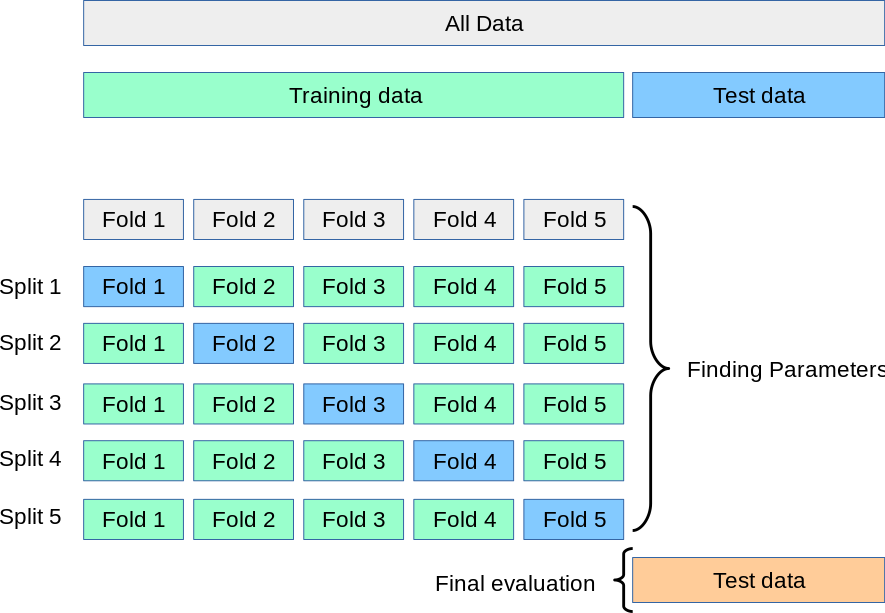
**Task P2.7: Implement the 5-fold cross validation to choose the best K (number of nearest neighbors) between 1 and 10 for KNN with Euclidean distance. Copy the code in the solution file and plot the 5-fold validation error with respect to K. Also plot the test error on the same figure. What do you observe?**

In [281]:
##STUDENT: YOUR CODE HERE



In [282]:
#Run below two lines (in google colab), installation steps to get .pdf of the notebook

!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [283]:
#Find path to your notebook file in drive and replace the path below between the quotes with you own path
!jupyter nbconvert --to PDF "gdrive/MyDrive/hw_ml/hw1/ProgAs1/KNN_assignment.ipynb"
# ! ls gdrive/MyDrive/hw_ml/Homework\ 1/ProgAs1/KNN_assignment.ipynb
# if "gdrive/My Drive/hw_ml"
# path="gdrive/My Drive/hw_ml/Homework 1/ProgAs1/KNN_assignment1.ipynb"
# import os
# print(os.path.curdir)


[NbConvertApp] Converting notebook gdrive/MyDrive/hw_ml/hw1/ProgAs1/KNN_assignment.ipynb to PDF
[NbConvertApp] Writing 109952 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: [u'xelatex', u'./notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))
(/usr/share/texlive/texmf-dist/tex/latex/tcolorbox/tcolorbox.sty
(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgf.sty
(/usr/share/texlive/texmf-dist/tex/latex/pgf/utilities/pgfrcs.sty
(/usr/share/texlive/tex

Congratulations! You have just implemented the KNN algorithm and tested it on the MNIST dataset!